In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import cv2
import sys
from google.colab import drive

drive.mount('/content/gdrive/')

my_local_drive='/content/gdrive/My Drive/Reconnaissance'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

Mounted at /content/gdrive/
/content/gdrive/My Drive/Reconnaissance


'/content/gdrive/My Drive/Reconnaissance'

On charge notre dataset des étudiants d'imagine en gardant les (n-1) premiers donc 95 images sur 100 images. (Il y a 5 images par étudiant)

In [2]:
n = 94

imgs =[]

#face 1 à n+1
for i in range(1,n+1):
    stri = 'imagine/croppedfaces64/face'+format(i, '03d')+'.jpg'
    img =cv2.imread(stri)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.ndarray.flatten(gray)
    imgs.append(gray)

On transforme notre tableau d'image en numpy array et on enlève la moyenne des visage afin de centrer notre nuage de point et de pouvoir calculer une ACP. 

In [3]:
numpy_array = np.array(imgs)
average = np.mean(numpy_array,axis=0)
numpy_array = numpy_array - np.tile(average,(numpy_array.shape[0],1))
transpose = numpy_array.T

On calcule le SVD pour avoir les eigenfaces ( la matrice U )


In [4]:
U, S, VT = np.linalg.svd(transpose,full_matrices=0)

On va garder dans un premier temps nos n premiers rangs de la matrice U, donc elle n'est pas tronquée on a le maximum de précision. Peut-être trop compte tenu du bruit ?

--> on passe de n à 6 -> mais reste à faire des tests plus précis en tenant compte du rappel et de la précision

On va donc essayer de reconstruire un visage inconnu du dataset dans l'espace des visages connus.



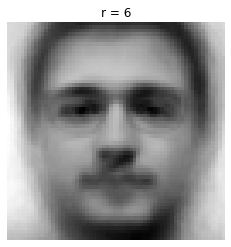

In [49]:
r = 6

#100 n'est pas dans le set

filepath = 'imagine/croppedfaces64/face100.jpg'
img =cv2.imread(filepath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
testFaceMS = np.ndarray.flatten(gray)-average


reconFace =  average + U[:,:r]  @ U[:,:r].T @ testFaceMS
img = plt.imshow(np.reshape(reconFace,(64,64)))
img.set_cmap('gray')
plt.title('r = ' + str(r))
plt.axis('off')
plt.show()


Dernière étape on calcule les poids de chaque image du dataset et on calcule la distance du visage inconnu à celui de tous les visages connus.


In [50]:
seuil = 900

w = testFaceMS @ U[:,:r]
weights = []
for ind,image in enumerate(numpy_array) :
    weight = image @ U[:,:r]
    dist = np.linalg.norm(weight-w)
    if dist<seuil :
      print(str(ind+1)+":"+str(dist))
    weights.append(weight)


r=n seuil 3000 On voit qu'il y a beaucoup de faux positif ! 


r=6 seuil 900 Aucun faux positif !

Autre cas un visage connu :


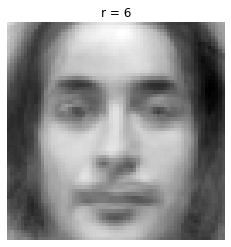

In [53]:
filepath = 'imagine/croppedfaces64/face090.jpg'
img =cv2.imread(filepath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
testFaceMS = np.ndarray.flatten(gray)-average


reconFace =  average + U[:,:r]  @ U[:,:r].T @ testFaceMS
img = plt.imshow(np.reshape(reconFace,(64,64)))
img.set_cmap('gray')
plt.title('r = ' + str(r))
plt.axis('off')
plt.show()

In [54]:
w = testFaceMS @ U[:,:r]
for ind, weight in enumerate(weights) :
    dist = np.linalg.norm(weight-w)
    if(dist < seuil):
      print(str(ind+1)+":"+str(dist))

86:866.6206652975299
87:361.80114010127613
89:602.8677553851343
90:0.0


Avec un seuil de 3000 on peut reconnaître ce visage !
Avec un seuil de 900 on reconnait 4/5 visage !
